# Summary: Key Figures for Korean Bias SAE Analysis

This notebook extracts and consolidates the most important visualizations from the analysis pipeline:

## Figures Included:

0. **Linear Probe Accuracy** (from 01_visualize_layer_demographic_comparison.ipynb)
   - **Justification for probing approach**: High accuracy confirms SAE features encode demographic information
   - Heatmap showing probe accuracy by layer and demographic

1. **IG² Score Comparison with Statistics Table** (from 01_visualize_layer_demographic_comparison.ipynb)
   - Heatmap showing max IG² scores with neuron indices for each demographic-layer combination
   - Statistics table with summary metrics

2. **Distribution of IG² Scores by Layer** (from 01_visualize_layer_demographic_comparison.ipynb)
   - Histograms showing score distribution aggregated across demographics

3. **Verification Heatmaps** (from 02_visualize_bias_feature_verification.ipynb)
   - Suppression effect (bias reduction when features zeroed)
   - Amplification effect (bias increase when features doubled)
   - Z-score statistical significance

4. **Feature Overlap Between Demographics** (from 03_analyze_important_neurons.ipynb)
   - Jaccard similarity heatmaps showing feature sharing at 99th percentile

5. **Feature Sharing Distribution** (deeper analysis of Figure 4)
   - Bar chart showing unique vs. shared features across demographics
   - Reveals whether bias encoding is demographic-specific or uses common mechanisms

## Data Source:
- Results from `results/full/{demographic}/` directories
- IG² scores, verification tests, and probe accuracy metrics

In [1]:
import os
import sys
import warnings
import pickle
from pathlib import Path
from collections import defaultdict

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Add project root to path
NOTEBOOK_DIR = Path(os.getcwd())
PROJECT_ROOT = NOTEBOOK_DIR.parent.parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

from src.visualization import ensure_korean_font
from src.utils import load_json

warnings.filterwarnings('ignore')

print(f"Project root: {PROJECT_ROOT}")

/home/youngjins/miniconda3/envs/belief_llm/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Project root: /home/youngjins/project/global_ai_frontier/korean-bias-sae


In [2]:
# Setup Korean font
font_name = ensure_korean_font()

# Plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.dpi'] = 100

Font configured: ['DejaVu Sans']


In [3]:
# Configuration
RESULTS_DIR = PROJECT_ROOT / "results"
DATA_DIR = PROJECT_ROOT / "data"
ASSETS_DIR = PROJECT_ROOT / "notebooks" / "visualizations" / "assets"
ASSETS_DIR.mkdir(exist_ok=True, parents=True)

# Stage
STAGE = "full"

# Layer quantiles to compare
LAYER_QUANTILES = ["q1", "q2", "q3"]
LAYER_LABELS = {
    "q1": "Layer 8",
    "q2": "Layer 16",
    "q3": "Layer 24"
}

# Load demographics
demo_dict = load_json(DATA_DIR / "demographic_dict_ko.json")
DEMOGRAPHICS = list(demo_dict.keys())
DEMOGRAPHIC_EN = {d: demo_dict[d]['dimension_en'] for d in DEMOGRAPHICS}

print(f"Stage: {STAGE}")
print(f"Layer Quantiles: {LAYER_QUANTILES}")
print(f"\nDemographics ({len(DEMOGRAPHICS)}):")
for d in DEMOGRAPHICS:
    print(f"  - {d} ({DEMOGRAPHIC_EN[d]})")

Stage: full
Layer Quantiles: ['q1', 'q2', 'q3']

Demographics (9):
  - 성별 (gender)
  - 인종 (ethnicity)
  - 종교 (religion)
  - 성적지향 (sexuality)
  - 나이 (age)
  - 외모 (physical appearance)
  - 경제수준 (socioeconomic status)
  - 정치성향 (politics)
  - 직업 (occupation)


---
## Data Loading Functions

In [4]:
def load_probe_results(results_dir, stage, demographic, layer_quantile):
    """
    Load linear probe training results.
    
    Returns:
        dict with 'accuracy', 'best_accuracy', 'losses', etc.
        or None if not found
    """
    # Use layer-specific filename (new format)
    probe_path = results_dir / stage / demographic / 'probe' / f'{layer_quantile}_linear_probe.pt'
    metrics_path = results_dir / stage / demographic / 'probe' / f'{layer_quantile}_training_metrics.pkl'
    
    # Fallback to legacy non-layer-specific path
    if not probe_path.exists():
        probe_path = results_dir / stage / demographic / 'probe' / 'linear_probe.pt'
        metrics_path = results_dir / stage / demographic / 'probe' / 'training_metrics.pkl'
    
    if not probe_path.exists():
        return None
    
    result = {}
    
    # Load probe checkpoint
    checkpoint = torch.load(probe_path, map_location='cpu')
    result['final_accuracy'] = checkpoint.get('final_accuracy', 0)
    result['best_accuracy'] = checkpoint.get('best_accuracy', 0)
    result['layer_quantile'] = checkpoint.get('layer_quantile', layer_quantile)
    
    # Load training metrics if available
    if metrics_path.exists():
        with open(metrics_path, 'rb') as f:
            metrics = pickle.load(f)
        result['losses'] = metrics.get('losses', [])
        result['accuracies'] = metrics.get('accuracies', [])
    
    return result


def load_ig2_results(results_dir, stage, demographic, layer_quantile):
    """
    Load IG² attribution results.
    
    Returns:
        dict with 'feature_scores', 'top_features', etc.
        or None if not found
    """
    # Use layer-specific filename (new format)
    ig2_path = results_dir / stage / demographic / 'ig2' / f'{layer_quantile}_ig2_results.pt'
    
    # Fallback to legacy non-layer-specific path
    if not ig2_path.exists():
        legacy_path = results_dir / stage / demographic / 'ig2' / 'ig2_results.pt'
        if legacy_path.exists():
            print(f"Warning: Using legacy IG2 file (no layer prefix): {legacy_path}")
            ig2_path = legacy_path
    
    if not ig2_path.exists():
        raise FileNotFoundError(f"IG² results not found: {ig2_path}")
    
    data = torch.load(ig2_path, map_location='cpu')
    return data


def load_verification_data(results_dir, stage, demographic, layer_quantile):
    """
    Load verification results for a specific demographic and layer.
    
    Supports both:
    - New structure: results/{stage}/{demographic}/verification/{layer_quantile}/
    - Legacy structure: results/{stage}/{demographic}/verification/
    
    Returns:
        dict with suppression, amplification, and random control data
        or None if not found
    """
    # Try new layer-specific structure first
    verif_dir = results_dir / stage / demographic / 'verification' / layer_quantile
    
    # Fallback to legacy structure (no layer subdirectory)
    if not verif_dir.exists():
        verif_dir = results_dir / stage / demographic / 'verification'
        if not verif_dir.exists():
            return None
    
    result = {'layer_quantile': layer_quantile}
    
    # Load suppression test
    suppress_path = verif_dir / 'suppression_test.json'
    if suppress_path.exists():
        result['suppression'] = load_json(suppress_path)
    
    # Load amplification test
    amplify_path = verif_dir / 'amplification_test.json'
    if amplify_path.exists():
        result['amplification'] = load_json(amplify_path)
    
    # Load random control
    random_path = verif_dir / 'random_control.json'
    if random_path.exists():
        result['random'] = load_json(random_path)
    
    return result if len(result) > 1 else None


print("Data loading functions defined.")

Data loading functions defined.


In [5]:
# Load all probe results
probe_data = defaultdict(lambda: defaultdict(dict))

print("Loading probe results...\n")

for demo in DEMOGRAPHICS:
    for lq in LAYER_QUANTILES:
        data = load_probe_results(RESULTS_DIR, STAGE, demo, lq)
        if data:
            probe_data[demo][lq] = data

# Load all IG² results
ig2_data = {}

print("Loading IG² results...\n")

for demo in DEMOGRAPHICS:
    ig2_data[demo] = {}
    for lq in LAYER_QUANTILES:
        try:
            data = load_ig2_results(RESULTS_DIR, STAGE, demo, lq)
            if data is not None:
                ig2_data[demo][lq] = data
        except FileNotFoundError:
            pass

# Load all verification results
verification_data = defaultdict(lambda: defaultdict(dict))

print("Loading verification results...\n")

for demo in DEMOGRAPHICS:
    for lq in LAYER_QUANTILES:
        data = load_verification_data(RESULTS_DIR, STAGE, demo, lq)
        if data:
            verification_data[demo][lq] = data

print("Data loading complete.")

Loading probe results...

Loading IG² results...

Loading verification results...

Data loading complete.


---
# Figure 0: Linear Probe Accuracy (Justification for Probing Approach)

## How It's Computed:
The linear probe is trained on SAE features to predict which demographic group generated each text. Accuracy = (correct predictions) / (total samples), measured on the validation set after training converges. Higher accuracy indicates SAE features successfully encode demographic-relevant information.

## Why This Matters:
**This figure justifies using the probing approach.** If the linear probe can accurately classify demographics based on SAE features, it confirms that:
1. The SAE has learned meaningful representations that capture demographic information
2. The probe's weights can be used with IG² to identify which specific features encode this information
3. The subsequent feature manipulation experiments (suppression/amplification) are grounded in features that demonstrably relate to demographic encoding

## Analysis:
High accuracy (near 100%) across all demographics and layers confirms that demographic bias is consistently encoded in the model's representations. Similar accuracy across layers suggests bias information persists throughout the model depth. Any demographic with lower accuracy may have more subtle or distributed bias encoding.

In [20]:
# Collect accuracy data
accuracy_data = []

for demo in DEMOGRAPHICS:
    for lq in LAYER_QUANTILES:
        if demo in probe_data and lq in probe_data[demo]:
            probe = probe_data[demo][lq]
            accuracy_data.append({
                'Demographic': demo,
                'Demographic_EN': DEMOGRAPHIC_EN[demo],
                'Layer': LAYER_LABELS[lq],
                'Layer_Quantile': lq,
                'Final_Accuracy': probe['final_accuracy'],
                'Best_Accuracy': probe['best_accuracy']
            })

df_accuracy = pd.DataFrame(accuracy_data)

if len(df_accuracy) > 0:
    print(f"Collected accuracy data for {len(df_accuracy)} experiments")
    print(df_accuracy)
else:
    print("No accuracy data found. Please run the training pipeline first.")

Collected accuracy data for 27 experiments
   Demographic        Demographic_EN     Layer Layer_Quantile  Final_Accuracy  \
0           성별                gender   Layer 8             q1        1.000000   
1           성별                gender  Layer 16             q2        1.000000   
2           성별                gender  Layer 24             q3        1.000000   
3           인종             ethnicity   Layer 8             q1        1.000000   
4           인종             ethnicity  Layer 16             q2        1.000000   
5           인종             ethnicity  Layer 24             q3        1.000000   
6           종교              religion   Layer 8             q1        1.000000   
7           종교              religion  Layer 16             q2        1.000000   
8           종교              religion  Layer 24             q3        1.000000   
9         성적지향             sexuality   Layer 8             q1        1.000000   
10        성적지향             sexuality  Layer 16             q2     

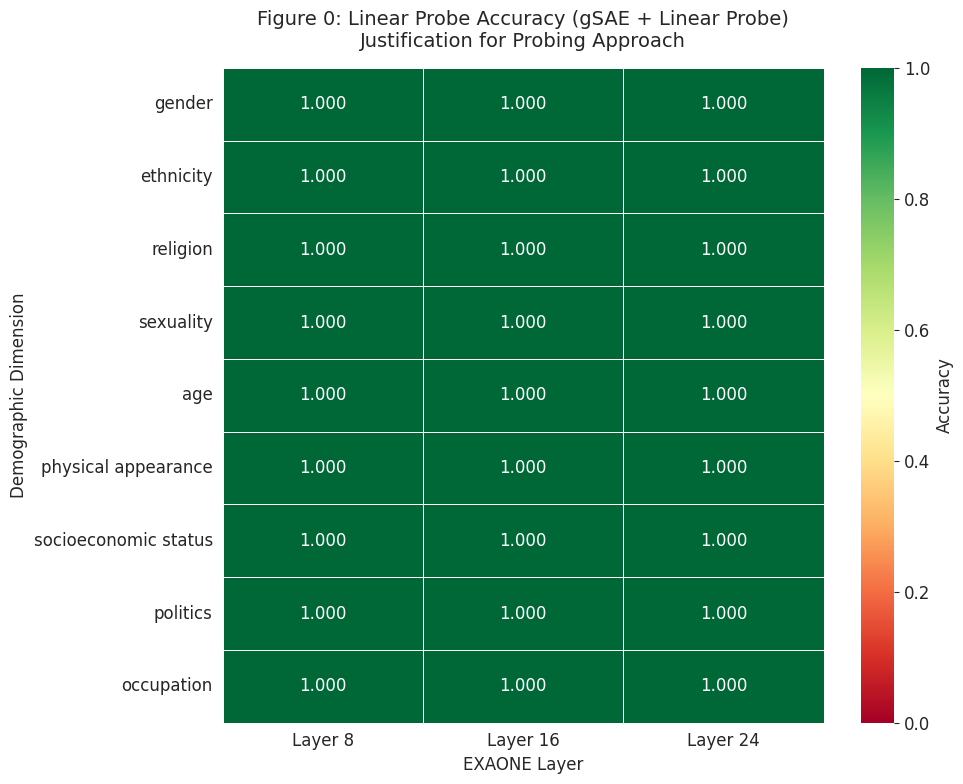


Probe Accuracy Statistics:

Layer 8:
  Mean Accuracy:   1.000
  Std Accuracy:    0.000
  Min Accuracy:    1.000
  Max Accuracy:    1.000

Layer 16:
  Mean Accuracy:   1.000
  Std Accuracy:    0.000
  Min Accuracy:    1.000
  Max Accuracy:    1.000

Layer 24:
  Mean Accuracy:   1.000
  Std Accuracy:    0.000
  Min Accuracy:    1.000
  Max Accuracy:    1.000

CONCLUSION: High probe accuracy across all demographics and layers
validates that SAE features successfully encode demographic information,
justifying the use of probing for bias feature identification.


In [7]:
if len(df_accuracy) > 0:
    # Create heatmap of accuracy by demographic and layer
    # Use English labels for the y-axis, preserve original demographic order
    
    # Create ordered list of English labels matching DEMOGRAPHICS order
    demo_en_ordered = [DEMOGRAPHIC_EN[d] for d in DEMOGRAPHICS]
    
    pivot_acc = df_accuracy.pivot(index='Demographic_EN', columns='Layer_Quantile', values='Best_Accuracy')
    pivot_acc = pivot_acc.reindex(demo_en_ordered)  # Reorder rows to match DEMOGRAPHICS order
    
    # Reorder columns
    pivot_acc = pivot_acc[['q1', 'q2', 'q3']]
    pivot_acc.columns = ['Layer 8', 'Layer 16', 'Layer 24']
    
    fig, ax = plt.subplots(figsize=(10, 8))
    
    sns.heatmap(
        pivot_acc,
        annot=True,
        fmt='.3f',
        cmap='RdYlGn',
        vmin=0.0,
        vmax=1.0,
        ax=ax,
        cbar_kws={'label': 'Accuracy'},
        linewidths=0.5
    )
    
    ax.set_title('Figure 0: Linear Probe Accuracy (gSAE + Linear Probe)\nJustification for Probing Approach', 
                 fontsize=14, pad=15)
    ax.set_xlabel('EXAONE Layer', fontsize=12)
    ax.set_ylabel('Demographic Dimension', fontsize=12)
    
    plt.tight_layout()
    plt.savefig(ASSETS_DIR / f"fig0_probe_accuracy_heatmap_{STAGE}.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print statistics
    print("\nProbe Accuracy Statistics:")
    print("=" * 60)
    for lq in ['q1', 'q2', 'q3']:
        lq_data = df_accuracy[df_accuracy['Layer_Quantile'] == lq]
        if len(lq_data) > 0:
            print(f"\n{LAYER_LABELS[lq]}:")
            print(f"  Mean Accuracy:   {lq_data['Best_Accuracy'].mean():.3f}")
            print(f"  Std Accuracy:    {lq_data['Best_Accuracy'].std():.3f}")
            print(f"  Min Accuracy:    {lq_data['Best_Accuracy'].min():.3f}")
            print(f"  Max Accuracy:    {lq_data['Best_Accuracy'].max():.3f}")
    
    # Overall summary
    print("\n" + "=" * 60)
    print("CONCLUSION: High probe accuracy across all demographics and layers")
    print("validates that SAE features successfully encode demographic information,")
    print("justifying the use of probing for bias feature identification.")
    print("=" * 60)

---
# Figure 1: IG² Score Comparison with Statistics Table

## How It's Computed:
IG² (Integrated Gradients Squared) measures each SAE feature's contribution to bias prediction by computing gradients along the path from zero to the actual feature value, then squaring and averaging. Higher IG² score means the feature is more important for the probe's demographic classification. Features above a threshold are labeled as "bias features."

## Analysis:
The heatmap shows the maximum IG² score (most important bias feature) for each demographic-layer combination, along with the neuron index. Higher scores indicate more concentrated bias encoding (fewer features carry most of the signal). Variation across layers reveals where in the model bias is most strongly encoded - typically middle layers (Q2) show balanced importance.

In [8]:
# Collect IG² statistics
ig2_stats = []

for demo in DEMOGRAPHICS:
    for lq in LAYER_QUANTILES:
        if lq in ig2_data[demo]:
            data = ig2_data[demo][lq]
            
            # Get feature scores
            if isinstance(data, dict):
                scores = data.get('feature_scores', data.get('ig2_scores', None))
            else:
                scores = data
            
            if scores is not None:
                if isinstance(scores, torch.Tensor):
                    scores_np = scores.cpu().numpy()
                else:
                    scores_np = scores
                
                # Compute statistics
                top_10 = np.sort(scores_np)[-10:]
                top_50 = np.sort(scores_np)[-50:]
                top_100 = np.sort(scores_np)[-100:]
                
                # Get the index of the max score (top neuron)
                max_neuron_idx = int(np.argmax(scores_np))
                
                ig2_stats.append({
                    'Demographic': demo,
                    'Demographic_EN': DEMOGRAPHIC_EN[demo],
                    'Layer': LAYER_LABELS[lq],
                    'Layer_Quantile': lq,
                    'Max_Score': scores_np.max(),
                    'Max_Neuron_Idx': max_neuron_idx,
                    'Top10_Mean': top_10.mean(),
                    'Top50_Mean': top_50.mean(),
                    'Top100_Mean': top_100.mean(),
                    'Total_Nonzero': (scores_np > 0).sum(),
                    'Scores': scores_np  # Keep for detailed analysis
                })

df_ig2 = pd.DataFrame(ig2_stats)

if len(df_ig2) > 0:
    print(f"Collected IG² data for {len(df_ig2)} experiments")
    print(df_ig2[['Demographic', 'Demographic_EN', 'Layer_Quantile', 'Max_Score', 'Max_Neuron_Idx', 'Top10_Mean', 'Total_Nonzero']].head(10))
else:
    print("No IG² data found. Please run the IG² computation pipeline first.")

Collected IG² data for 27 experiments
  Demographic Demographic_EN Layer_Quantile  Max_Score  Max_Neuron_Idx  \
0          성별         gender             q1   0.387639           53911   
1          성별         gender             q2   0.437685           67974   
2          성별         gender             q3   0.448949           71521   
3          인종      ethnicity             q1   0.687645           12574   
4          인종      ethnicity             q2   0.497052           83760   
5          인종      ethnicity             q3   0.493965           70570   
6          종교       religion             q1   0.622936           38258   
7          종교       religion             q2   0.543364           67974   
8          종교       religion             q3   0.526453           70570   
9        성적지향      sexuality             q1   0.573826           38258   

   Top10_Mean  Total_Nonzero  
0    0.301691            192  
1    0.301581            635  
2    0.321749           2294  
3    0.399523          

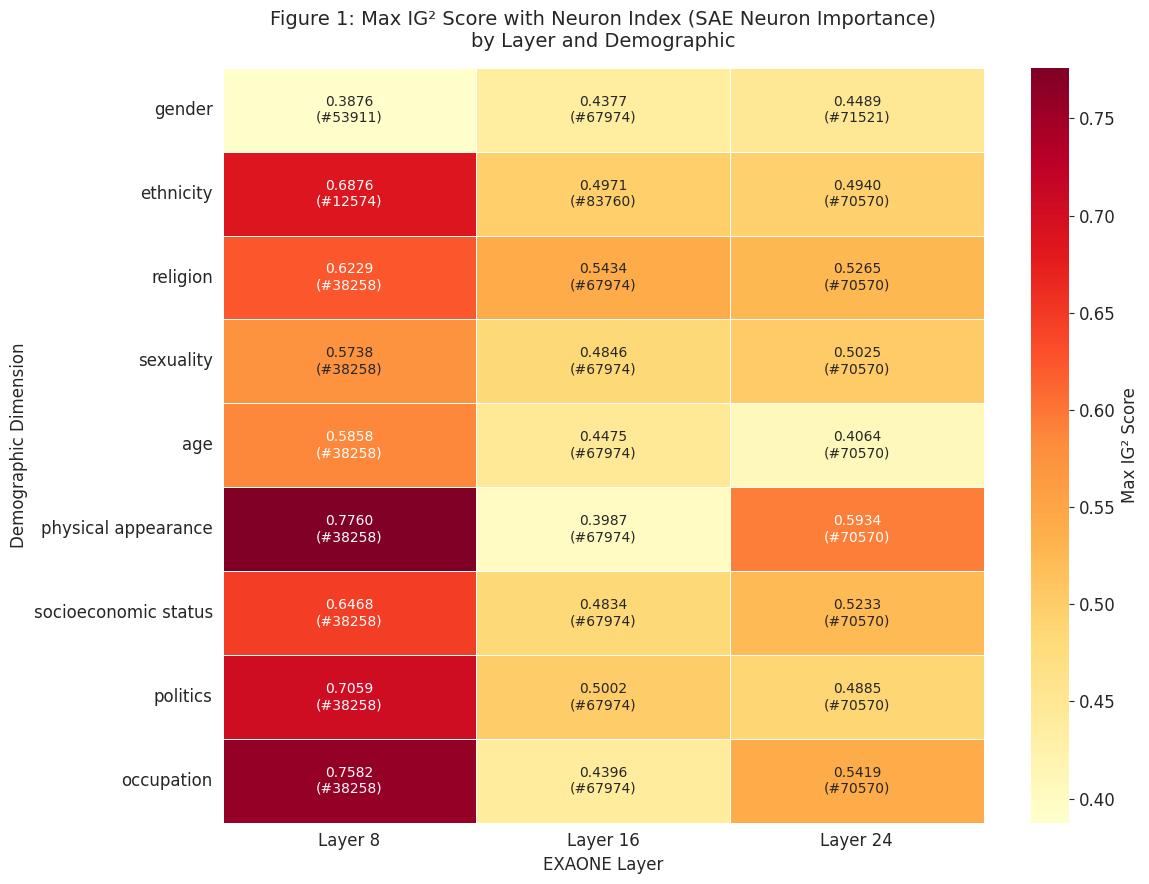


Statistics Table: Top Neuron Indices (Max IG² Score) per Demographic:
Demographic                            Layer 8             Layer 16             Layer 24
--------------------------------------------------------------------------------
gender                    #53911 (0.388) #67974 (0.438) #71521 (0.449)
ethnicity                 #12574 (0.688) #83760 (0.497) #70570 (0.494)
religion                  #38258 (0.623) #67974 (0.543) #70570 (0.526)
sexuality                 #38258 (0.574) #67974 (0.485) #70570 (0.503)
age                       #38258 (0.586) #67974 (0.447) #70570 (0.406)
physical appearance       #38258 (0.776) #67974 (0.399) #70570 (0.593)
socioeconomic status      #38258 (0.647) #67974 (0.483) #70570 (0.523)
politics                  #38258 (0.706) #67974 (0.500) #70570 (0.488)
occupation                #38258 (0.758) #67974 (0.440) #70570 (0.542)


In [9]:
if len(df_ig2) > 0:
    # Heatmap of max IG² scores with neuron indices
    # Use English labels for the y-axis, preserve original demographic order
    
    # Create ordered list of English labels matching DEMOGRAPHICS order
    demo_en_ordered = [DEMOGRAPHIC_EN[d] for d in DEMOGRAPHICS]
    
    # Pivot and reindex to maintain original order
    pivot_ig2 = df_ig2.pivot(index='Demographic_EN', columns='Layer_Quantile', values='Max_Score')
    pivot_ig2 = pivot_ig2.reindex(demo_en_ordered)  # Reorder rows to match DEMOGRAPHICS order
    pivot_ig2 = pivot_ig2[['q1', 'q2', 'q3']]
    pivot_ig2.columns = ['Layer 8', 'Layer 16', 'Layer 24']
    
    # Also get neuron indices for annotations
    pivot_neuron = df_ig2.pivot(index='Demographic_EN', columns='Layer_Quantile', values='Max_Neuron_Idx')
    pivot_neuron = pivot_neuron.reindex(demo_en_ordered)  # Same reordering
    pivot_neuron = pivot_neuron[['q1', 'q2', 'q3']]
    pivot_neuron.columns = ['Layer 8', 'Layer 16', 'Layer 24']
    
    # Create custom annotations with score and neuron index
    annot_labels = []
    for idx in pivot_ig2.index:
        row_labels = []
        for col in pivot_ig2.columns:
            score = pivot_ig2.loc[idx, col]
            neuron_idx = int(pivot_neuron.loc[idx, col])
            row_labels.append(f'{score:.4f}\n(#{neuron_idx})')
        annot_labels.append(row_labels)
    annot_array = np.array(annot_labels)
    
    fig, ax = plt.subplots(figsize=(12, 9))
    
    sns.heatmap(
        pivot_ig2,
        annot=annot_array,
        fmt='',
        cmap='YlOrRd',
        ax=ax,
        cbar_kws={'label': 'Max IG² Score'},
        linewidths=0.5,
        annot_kws={'fontsize': 10}
    )
    
    ax.set_title('Figure 1: Max IG² Score with Neuron Index (SAE Neuron Importance)\nby Layer and Demographic', 
                 fontsize=14, pad=15)
    ax.set_xlabel('EXAONE Layer', fontsize=12)
    ax.set_ylabel('Demographic Dimension', fontsize=12)
    
    plt.tight_layout()
    plt.savefig(ASSETS_DIR / f"fig1_ig2_max_scores_heatmap_{STAGE}.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print top neuron indices per demographic (in same order as heatmap)
    print("\nStatistics Table: Top Neuron Indices (Max IG² Score) per Demographic:")
    print("=" * 80)
    print(f"{'Demographic':<25} {'Layer 8':>20} {'Layer 16':>20} {'Layer 24':>20}")
    print("-" * 80)
    for demo_en in demo_en_ordered:
        demo_data = df_ig2[df_ig2['Demographic_EN'] == demo_en]
        row = f"{demo_en:<25}"
        for lq in ['q1', 'q2', 'q3']:
            lq_data = demo_data[demo_data['Layer_Quantile'] == lq]
            if len(lq_data) > 0:
                neuron_idx = lq_data['Max_Neuron_Idx'].values[0]
                score = lq_data['Max_Score'].values[0]
                row += f" #{neuron_idx:5d} ({score:.3f})"
            else:
                row += f" {'--':>18}"
        print(row)
    print("=" * 80)

---
# Figure 2: Distribution of IG² Scores by Layer

## How It's Computed:
This histogram shows the distribution of all non-zero IG² scores across demographics for each layer. Scores are aggregated from all 9 demographic dimensions to show the overall distribution pattern.

## Analysis:
A long-tailed distribution with few high-scoring features indicates concentrated bias encoding (good for targeted intervention). More uniform distributions suggest diffuse bias encoding across many features. The log-scale y-axis helps visualize the full range of feature frequencies.

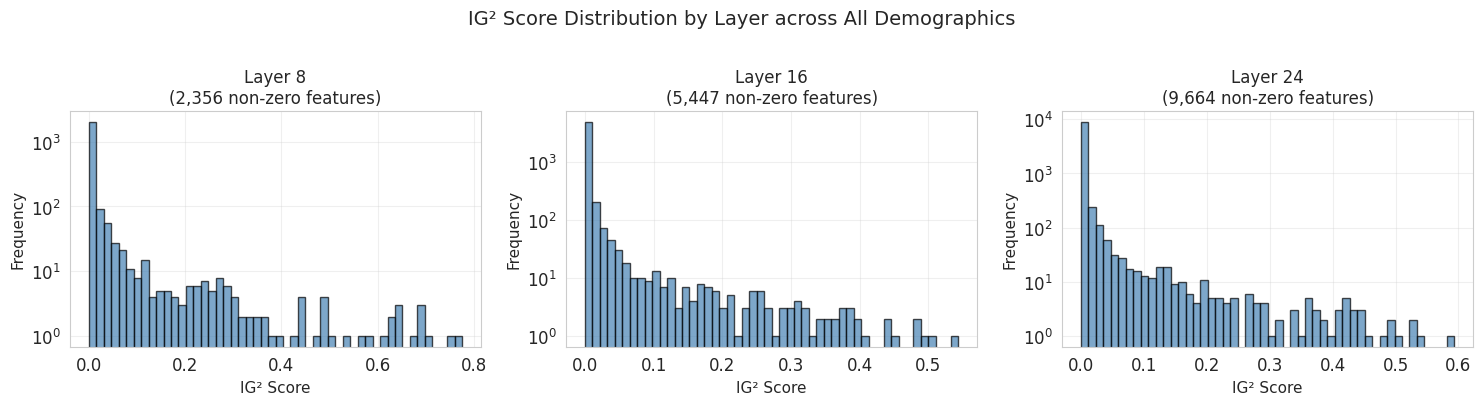

In [22]:
if len(df_ig2) > 0:
    # Distribution of IG² scores for each layer (aggregated across demographics)
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    for idx, lq in enumerate(LAYER_QUANTILES):
        ax = axes[idx]
        
        lq_data = df_ig2[df_ig2['Layer_Quantile'] == lq]
        
        if len(lq_data) > 0:
            # Concatenate all scores for this layer
            all_scores = np.concatenate([row['Scores'] for _, row in lq_data.iterrows()])
            
            # Plot histogram (only positive scores)
            positive_scores = all_scores[all_scores > 0]
            ax.hist(positive_scores, bins=50, color='steelblue', alpha=0.7, edgecolor='black')
            ax.set_xlabel('IG² Score', fontsize=11)
            ax.set_ylabel('Frequency', fontsize=11)
            ax.set_title(f'{LAYER_LABELS[lq]}\n({len(positive_scores):,} non-zero features)', fontsize=12)
            ax.set_yscale('log')
            ax.grid(alpha=0.3)
    
    plt.suptitle('IG² Score Distribution by Layer across All Demographics', fontsize=14, y=1.01)
    plt.tight_layout()
    plt.savefig(ASSETS_DIR / f"fig2_ig2_distribution_by_layer_{STAGE}.png", dpi=300, bbox_inches='tight')
    plt.show()

---
# Figure 3: Verification Heatmaps (Suppression, Amplification, Z-Score)

## How It's Computed:

### (1) Suppression Effect:
Suppression sets identified bias features to zero and measures the change in logit gap (difference between correct and incorrect demographic predictions). The change ratio = (gap_after - gap_before) / gap_before. Negative values indicate bias reduction - the model becomes less confident in distinguishing demographics.

### (2) Amplification Effect:
Amplification multiplies identified bias features by 2 (doubling their activation magnitude) and measures the change in logit gap. Positive values indicate bias amplification - the model becomes more confident in distinguishing demographics.

### (3) Z-Score (Statistical Significance):
Z-score compares the suppression effect to random control: Z = (suppress_change - random_mean) / random_std. It measures how many standard deviations the bias feature suppression differs from suppressing random features. |Z| > 2 indicates statistical significance (p < 0.05).

## Statistical Background:
- **Null Hypothesis (H₀)**: "Suppressing bias features has the same effect as suppressing random features."
- **Alternative Hypothesis (H₁)**: "Suppressing bias features has a significantly different effect than random features."
- The threshold |Z| > 1.96 ≈ 2 corresponds to p < 0.05 (95% confidence).

## Analysis:
- Green cells in suppression (negative values) = successful bias reduction
- Red cells in amplification (positive values) = successful bias increase  
- True in Z-score panel = statistically significant effect (|Z| > 2)

In [11]:
# Create comprehensive verification dataframe
verif_summary_data = []

for demo in DEMOGRAPHICS:
    for lq in LAYER_QUANTILES:
        if demo not in verification_data or lq not in verification_data[demo]:
            continue
        
        data = verification_data[demo][lq]
        
        row = {
            'Demographic': demo,
            'Demographic_EN': DEMOGRAPHIC_EN[demo],
            'Layer': LAYER_LABELS[lq],
            'Layer_Quantile': lq,
        }
        
        # Suppression data
        if 'suppression' in data:
            supp = data['suppression']
            row['Suppress_Gap_Before'] = supp.get('gap_before', 0)
            row['Suppress_Gap_After'] = supp.get('gap_after', 0)
            row['Suppress_Change_Ratio'] = supp.get('gap_change_ratio', 0)
            row['Suppress_Num_Features'] = supp.get('metadata', {}).get('num_features_manipulated', 0)
        
        # Amplification data
        if 'amplification' in data:
            amp = data['amplification']
            row['Amplify_Gap_Before'] = amp.get('gap_before', 0)
            row['Amplify_Gap_After'] = amp.get('gap_after', 0)
            row['Amplify_Change_Ratio'] = amp.get('gap_change_ratio', 0)
        
        # Random control data and Z-score
        if 'random' in data:
            rand = data['random']
            row['Random_Mean_Change'] = rand.get('mean_gap_change', 0)
            row['Random_Std_Change'] = rand.get('std_gap_change', 0)
            
            # Calculate Z-score for suppression effect
            if row.get('Suppress_Change_Ratio') is not None and rand.get('std_gap_change', 0) > 0:
                z_score = (row['Suppress_Change_Ratio'] - rand['mean_gap_change']) / rand['std_gap_change']
                row['Z_Score'] = z_score
            else:
                row['Z_Score'] = 0
        
        verif_summary_data.append(row)

df_verif = pd.DataFrame(verif_summary_data)

if len(df_verif) > 0:
    print(f"\nCollected verification data for {len(df_verif)} experiments")
else:
    print("No verification data found.")


Collected verification data for 27 experiments


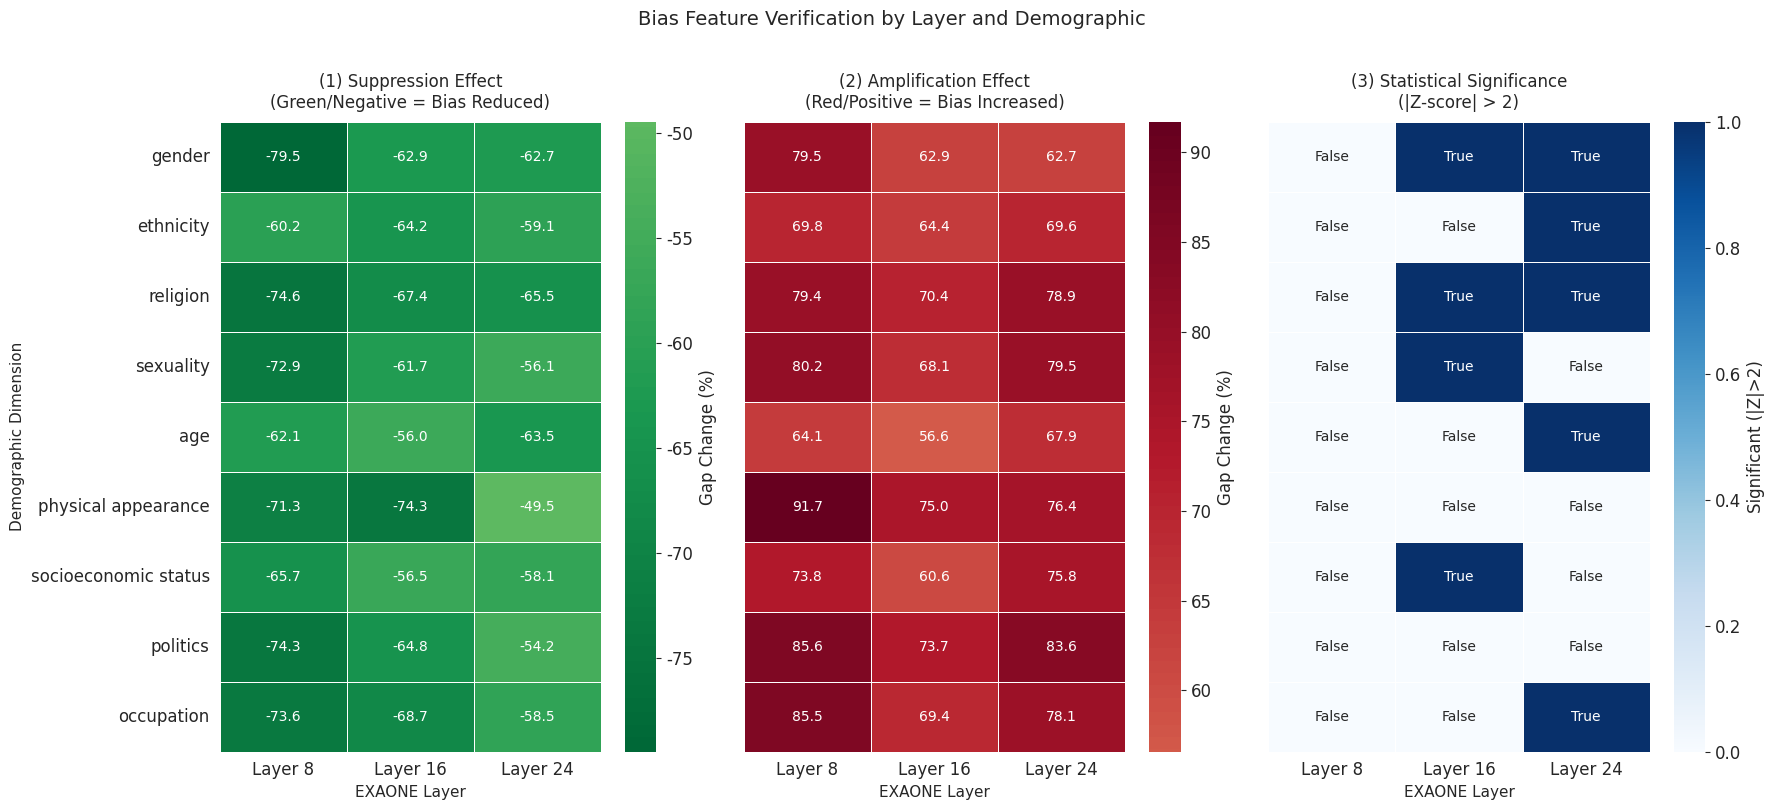


Statistical Significance (|Z-score| > 2) Heatmap Data:
                      Layer 8  Layer 16  Layer 24
Demographic_EN                                   
gender                      0         1         1
ethnicity                   0         0         1
religion                    0         1         1
sexuality                   0         1         0
age                         0         0         1
physical appearance         0         0         0
socioeconomic status        0         1         0
politics                    0         0         0
occupation                  0         0         1


In [33]:
if len(df_verif) > 0:
    # Create ordered list of English labels matching DEMOGRAPHICS order
    demo_en_ordered = [DEMOGRAPHIC_EN[d] for d in DEMOGRAPHICS]
    
    # ============================================
    # COMBINED HEATMAP: Suppression, Amplification, Statistical Significance
    # ============================================
    fig, axes = plt.subplots(1, 3, figsize=(18, 8))
    
    # --- (1) Suppression Effect ---
    ax1 = axes[0]
    pivot_suppress = df_verif.pivot(index='Demographic_EN', columns='Layer_Quantile', values='Suppress_Change_Ratio')
    pivot_suppress = pivot_suppress.reindex(demo_en_ordered)
    pivot_suppress = pivot_suppress[['q1', 'q2', 'q3']] * 100  # Convert to percentage
    pivot_suppress.columns = ['Layer 8', 'Layer 16', 'Layer 24']
    
    sns.heatmap(
        pivot_suppress,
        annot=True,
        fmt='.1f',
        cmap='RdYlGn_r',
        center=0,
        ax=ax1,
        cbar_kws={'label': 'Gap Change (%)'},
        linewidths=0.5,
        annot_kws={'fontsize': 10}
    )
    ax1.set_title('(1) Suppression Effect\n(Green/Negative = Bias Reduced)', fontsize=12, pad=10)
    ax1.set_xlabel('EXAONE Layer', fontsize=11)
    ax1.set_ylabel('Demographic Dimension', fontsize=11)
    
    # --- (2) Amplification Effect (no y-axis) ---
    ax2 = axes[1]
    pivot_amplify = df_verif.pivot(index='Demographic_EN', columns='Layer_Quantile', values='Amplify_Change_Ratio')
    pivot_amplify = pivot_amplify.reindex(demo_en_ordered)
    pivot_amplify = pivot_amplify[['q1', 'q2', 'q3']] * 100
    pivot_amplify.columns = ['Layer 8', 'Layer 16', 'Layer 24']
    
    sns.heatmap(
        pivot_amplify,
        annot=True,
        fmt='.1f',
        cmap='RdBu_r',
        center=0,
        ax=ax2,
        cbar_kws={'label': 'Gap Change (%)'},
        linewidths=0.5,
        annot_kws={'fontsize': 10}
    )
    ax2.set_title('(2) Amplification Effect\n(Red/Positive = Bias Increased)', fontsize=12, pad=10)
    ax2.set_xlabel('EXAONE Layer', fontsize=11)
    ax2.set_ylabel('')  # Remove y-axis label
    ax2.set_yticklabels([])  # Remove y-axis tick labels
    
    # --- (3) Statistical Significance (True/False, blue colormap, no y-axis) ---
    ax3 = axes[2]
    pivot_sig = df_verif.pivot(index='Demographic_EN', columns='Layer_Quantile', values='Z_Score')
    pivot_sig = pivot_sig.reindex(demo_en_ordered)
    pivot_sig = pivot_sig[['q1', 'q2', 'q3']]
    # Convert to True/False based on |Z| > 2
    pivot_sig_bool = (abs(pivot_sig) > 2).astype(int)
    pivot_sig_bool.columns = ['Layer 8', 'Layer 16', 'Layer 24']
    
    # Create annotation labels as "True" or "False"
    annot_labels = pivot_sig_bool.applymap(lambda x: 'True' if x == 1 else 'False')
    
    sns.heatmap(
        pivot_sig_bool,
        annot=annot_labels,
        fmt='',
        cmap='Blues',  # Blue colormap for significance
        vmin=0,
        vmax=1,
        ax=ax3,
        cbar_kws={'label': 'Significant (|Z|>2)'},
        linewidths=0.5,
        annot_kws={'fontsize': 10}
    )
    ax3.set_title('(3) Statistical Significance\n(|Z-score| > 2)', fontsize=12, pad=10)
    ax3.set_xlabel('EXAONE Layer', fontsize=11)
    ax3.set_ylabel('')  # Remove y-axis label
    ax3.set_yticklabels([])  # Remove y-axis tick labels
    
    plt.suptitle('Bias Feature Verification by Layer and Demographic', 
                 fontsize=14, y=1.01)
    plt.tight_layout()
    plt.savefig(ASSETS_DIR / f"fig3_verification_combined_heatmap_{STAGE}.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    # print heatmap for (3)
    print("\nStatistical Significance (|Z-score| > 2) Heatmap Data:")
    print(pivot_sig_bool)
else:
    print("No verification data available.")

---
# Figure 4: Feature Overlap Between Demographics (Jaccard Similarity)

## How It's Computed:
For each layer, we compute Jaccard similarity between all pairs of demographics: J(A,B) = |A∩B| / |A∪B|, where A and B are sets of important feature indices (99th percentile of IG² scores). Higher similarity means demographics share more bias-encoding features.

## Analysis:
- High similarity across demographics within a layer suggests common bias-encoding mechanisms (features that encode "group identity" rather than specific biases)
- Low similarity means demographic-specific encoding
- Comparing across layers reveals where bias is most/least generalized

In [13]:
def filter_features_by_percentile(scores, percentile):
    """
    Filter features by percentile threshold on non-zero scores.
    
    Args:
        scores: numpy array of IG² scores
        percentile: percentile threshold (e.g., 95, 99)
    
    Returns:
        important_indices: indices of features above threshold
        threshold: computed threshold value
    """
    nonzero_scores = scores[scores > 0]
    if len(nonzero_scores) == 0:
        return np.array([]), 0.0
    
    threshold = np.percentile(nonzero_scores, percentile)
    important_indices = np.where(scores >= threshold)[0]
    return important_indices, threshold


def compute_jaccard_similarity(set_a, set_b):
    """Compute Jaccard similarity between two sets."""
    set_a = set(set_a)
    set_b = set(set_b)
    
    intersection = len(set_a & set_b)
    union = len(set_a | set_b)
    
    if union == 0:
        return 0.0
    return intersection / union


print("Helper functions defined.")

Helper functions defined.


In [14]:
# Compute important feature indices for each demographic-layer
important_features = defaultdict(lambda: defaultdict(dict))

for demo in DEMOGRAPHICS:
    for lq in LAYER_QUANTILES:
        if lq in ig2_data[demo]:
            data = ig2_data[demo][lq]
            
            # Get feature scores
            if isinstance(data, dict):
                scores = data.get('feature_scores', data.get('ig2_scores', None))
            else:
                scores = data
            
            if scores is not None:
                if isinstance(scores, torch.Tensor):
                    scores_np = scores.cpu().numpy()
                else:
                    scores_np = scores
                
                # Get 99th percentile features
                indices, threshold = filter_features_by_percentile(scores_np, 99)
                important_features[demo][lq] = {
                    'indices': indices,
                    'threshold': threshold
                }

print("Computed important feature indices (99th percentile).")

Computed important feature indices (99th percentile).


In [15]:
# Compute Jaccard similarity matrices for each layer
jaccard_matrices = {}

for lq in LAYER_QUANTILES:
    n_demo = len(DEMOGRAPHICS)
    matrix = np.zeros((n_demo, n_demo))
    
    for i, demo_i in enumerate(DEMOGRAPHICS):
        for j, demo_j in enumerate(DEMOGRAPHICS):
            if i == j:
                matrix[i, j] = 1.0
            else:
                # Get important features for both demographics
                if lq in important_features[demo_i] and lq in important_features[demo_j]:
                    indices_i = important_features[demo_i][lq]['indices']
                    indices_j = important_features[demo_j][lq]['indices']
                    matrix[i, j] = compute_jaccard_similarity(indices_i, indices_j)
    
    jaccard_matrices[lq] = matrix

print("Jaccard similarity matrices computed for each layer.")

Jaccard similarity matrices computed for each layer.


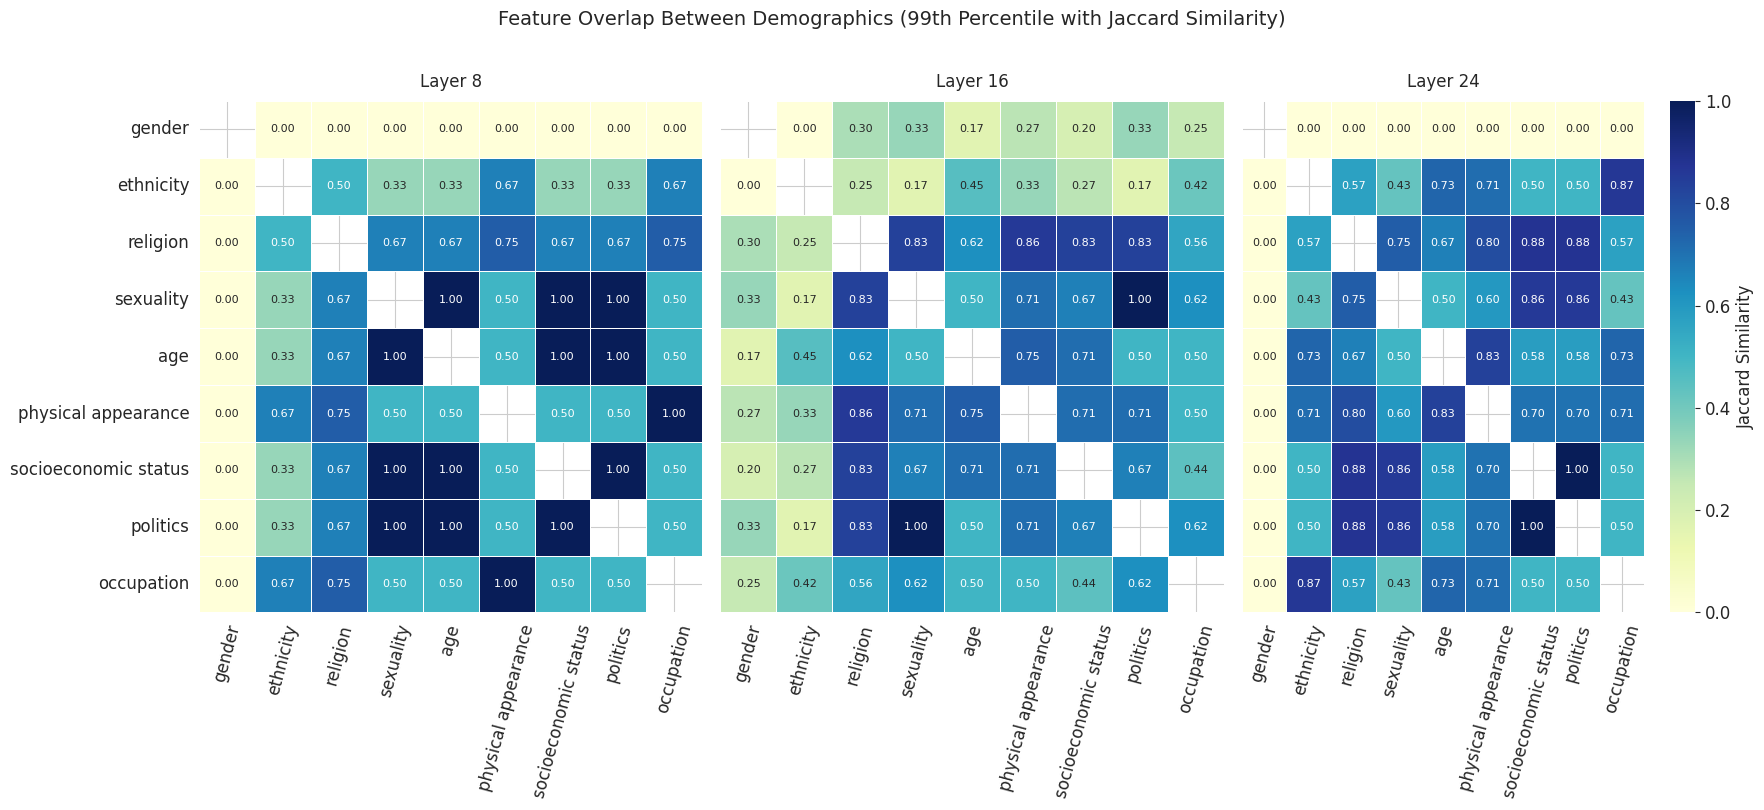


Average Jaccard Similarity (excluding diagonal):
  Layer 8: 0.509 (std=0.340)
  Layer 16: 0.502 (std=0.241)
  Layer 24: 0.526 (std=0.312)


In [24]:
# Visualize Jaccard similarity heatmaps
fig, axes = plt.subplots(1, 3, figsize=(18, 8))

demo_en_labels = [DEMOGRAPHIC_EN[d] for d in DEMOGRAPHICS]

for idx, lq in enumerate(LAYER_QUANTILES):
    ax = axes[idx]
    
    matrix = jaccard_matrices[lq]
    
    # Create DataFrame for better labeling
    df_matrix = pd.DataFrame(matrix, index=demo_en_labels, columns=demo_en_labels)
    
    # Mask diagonal for cleaner visualization
    mask = np.eye(len(DEMOGRAPHICS), dtype=bool)
    
    sns.heatmap(
        df_matrix,
        annot=True,
        fmt='.2f',
        cmap='YlGnBu',
        vmin=0,
        vmax=1,
        ax=ax,
        mask=mask,
        cbar=True if idx == 2 else False,
        cbar_kws={'label': 'Jaccard Similarity'} if idx == 2 else None,
        linewidths=0.5,
        annot_kws={'fontsize': 8}
    )
    
    ax.set_title(f'{LAYER_LABELS[lq]}', fontsize=12, pad=10)
    ax.tick_params(axis='x', rotation=75)  # Set x-axis rotation to 75 degrees
    ax.tick_params(axis='y', rotation=0)
    
    # Remove y-axis for Layer 16 and Layer 24 (idx > 0)
    if idx > 0:
        ax.set_ylabel('')
        ax.set_yticklabels([])

plt.suptitle('Feature Overlap Between Demographics (99th Percentile with Jaccard Similarity)', 
             fontsize=14, y=1.01)
plt.tight_layout()
plt.savefig(ASSETS_DIR / f"fig4_jaccard_similarity_{STAGE}.png", dpi=300, bbox_inches='tight')
plt.show()

# Print average similarity per layer
print("\nAverage Jaccard Similarity (excluding diagonal):")
print("=" * 60)
for lq in LAYER_QUANTILES:
    matrix = jaccard_matrices[lq]
    # Get off-diagonal elements
    off_diag = matrix[~np.eye(matrix.shape[0], dtype=bool)]
    print(f"  {LAYER_LABELS[lq]}: {off_diag.mean():.3f} (std={off_diag.std():.3f})")

---
# Figure 5: Feature Sharing Distribution

## How It's Computed:
For each layer, we collect all important features (99th percentile) across all 9 demographics and count how many demographics share each feature. Features are then grouped by their sharing count: unique (1 demographic), partially shared (2-4 demographics), or universal (5+ demographics).

## Why This Matters:
This analysis reveals the nature of bias encoding in the model:
- **Many unique features** → Bias encoding is demographic-specific (each demographic has its own distinct features)
- **Many shared features** → Bias encoding uses common mechanisms (a smaller set of "group identity" features)

## Analysis:
A distribution skewed toward unique features suggests targeted, demographic-specific interventions are needed. A distribution with many shared features suggests that intervening on a small set of universal features could reduce bias across multiple demographics simultaneously.

In [17]:
# Compute feature sharing distribution for each layer
sharing_data = []

for lq in LAYER_QUANTILES:
    # Collect all important features for this layer
    all_features = {}
    for demo in DEMOGRAPHICS:
        if lq in important_features[demo]:
            all_features[demo] = set(important_features[demo][lq]['indices'])
    
    # Count how many demographics each feature appears in
    feature_counts = defaultdict(int)
    for demo, features in all_features.items():
        for f in features:
            feature_counts[f] += 1
    
    # Group by sharing count
    for feature_idx, count in feature_counts.items():
        sharing_data.append({
            'Layer': lq,
            'Layer_Label': LAYER_LABELS[lq],
            'Feature_Index': feature_idx,
            'Shared_By_N_Demographics': count
        })

df_sharing = pd.DataFrame(sharing_data)

# Create distribution summary
distribution_summary = []
for lq in LAYER_QUANTILES:
    lq_data = df_sharing[df_sharing['Layer'] == lq]
    total = len(lq_data)
    
    for n in range(1, 10):  # 1 to 9 demographics
        count = len(lq_data[lq_data['Shared_By_N_Demographics'] == n])
        if count > 0:
            distribution_summary.append({
                'Layer': LAYER_LABELS[lq],
                'Shared_By': n,
                'Feature_Count': count,
                'Percentage': count / total * 100 if total > 0 else 0
            })

df_distribution = pd.DataFrame(distribution_summary)
print("Feature sharing distribution computed.")
print(df_distribution)

Feature sharing distribution computed.
       Layer  Shared_By  Feature_Count  Percentage
0    Layer 8          1              4   50.000000
1    Layer 8          3              1   12.500000
2    Layer 8          4              1   12.500000
3    Layer 8          8              2   25.000000
4   Layer 16          1              6   37.500000
5   Layer 16          2              2   12.500000
6   Layer 16          3              2   12.500000
7   Layer 16          5              1    6.250000
8   Layer 16          6              1    6.250000
9   Layer 16          8              4   25.000000
10  Layer 24          1             26   66.666667
11  Layer 24          2              2    5.128205
12  Layer 24          3              1    2.564103
13  Layer 24          4              2    5.128205
14  Layer 24          5              1    2.564103
15  Layer 24          7              1    2.564103
16  Layer 24          8              6   15.384615


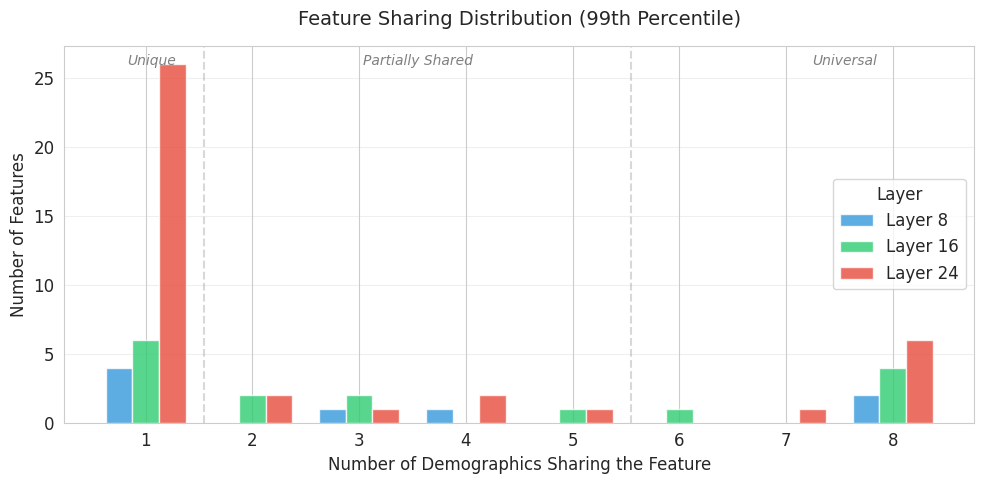


Feature Sharing Summary:

Layer 8 (8 total features):
  Unique (1 demo):             4 (50.0%)
  Partially shared (2-4):      2 (25.0%)
  Universal (5+ demos):        2 (25.0%)

Layer 16 (16 total features):
  Unique (1 demo):             6 (37.5%)
  Partially shared (2-4):      4 (25.0%)
  Universal (5+ demos):        6 (37.5%)

Layer 24 (39 total features):
  Unique (1 demo):            26 (66.7%)
  Partially shared (2-4):      5 (12.8%)
  Universal (5+ demos):        8 (20.5%)

INSIGHT: Features shared by 5+ demographics are 'universal bias features'
that may encode general group identity rather than specific demographic bias.


In [32]:
# Visualize feature sharing distribution
fig, ax = plt.subplots(figsize=(10, 5))

# Pivot for grouped bar chart
pivot = df_distribution.pivot(index='Shared_By', columns='Layer', values='Feature_Count')
pivot = pivot.fillna(0).astype(int)
pivot = pivot[['Layer 8', 'Layer 16', 'Layer 24']]  # Reorder columns

# Create grouped bar chart
x = np.arange(len(pivot.index))
width = 0.25
colors = ['#3498db', '#2ecc71', '#e74c3c']  # Blue, Green, Red

for i, (col, color) in enumerate(zip(pivot.columns, colors)):
    ax.bar(x + i * width, pivot[col], width, label=col, color=color, alpha=0.8)

ax.set_xlabel('Number of Demographics Sharing the Feature', fontsize=12)
ax.set_ylabel('Number of Features', fontsize=12)
ax.set_title('Feature Sharing Distribution (99th Percentile)', 
             fontsize=14, pad=15)
ax.set_xticks(x + width)
ax.set_xticklabels(pivot.index)
ax.legend(title='Layer', loc='center right')
ax.grid(axis='y', alpha=0.3)

# Add category labels
ax.axvline(x=0.8, color='gray', linestyle='--', alpha=0.3)
ax.axvline(x=4.8, color='gray', linestyle='--', alpha=0.3)
ax.text(0.3, ax.get_ylim()[1] * 0.95, 'Unique', fontsize=10, ha='center', style='italic', color='gray')
ax.text(2.8, ax.get_ylim()[1] * 0.95, 'Partially Shared', fontsize=10, ha='center', style='italic', color='gray')
ax.text(6.8, ax.get_ylim()[1] * 0.95, 'Universal', fontsize=10, ha='center', style='italic', color='gray')

plt.tight_layout()
plt.savefig(ASSETS_DIR / f"fig5_feature_sharing_distribution_{STAGE}.png", dpi=300, bbox_inches='tight')
plt.show()

# Print summary statistics
print("\nFeature Sharing Summary:")
print("=" * 70)
for lq in LAYER_QUANTILES:
    lq_data = df_sharing[df_sharing['Layer'] == lq]
    total = len(lq_data)
    unique = len(lq_data[lq_data['Shared_By_N_Demographics'] == 1])
    partial = len(lq_data[(lq_data['Shared_By_N_Demographics'] >= 2) & (lq_data['Shared_By_N_Demographics'] <= 4)])
    universal = len(lq_data[lq_data['Shared_By_N_Demographics'] >= 5])
    
    print(f"\n{LAYER_LABELS[lq]} ({total} total features):")
    print(f"  Unique (1 demo):           {unique:3d} ({unique/total*100:.1f}%)")
    print(f"  Partially shared (2-4):    {partial:3d} ({partial/total*100:.1f}%)")
    print(f"  Universal (5+ demos):      {universal:3d} ({universal/total*100:.1f}%)")

print("\n" + "=" * 70)
print("INSIGHT: Features shared by 5+ demographics are 'universal bias features'")
print("that may encode general group identity rather than specific demographic bias.")
print("=" * 70)

---
# Summary

This notebook extracted the 6 key figures from the Korean Bias SAE analysis:

0. **Figure 0**: Probe Accuracy - **Justifies the probing approach** by showing high classification accuracy across all demographics and layers
1. **Figure 1**: IG² Score Comparison - Shows max importance scores and neuron indices for each demographic-layer combination
2. **Figure 2**: IG² Distribution - Histograms showing the spread of importance scores across layers
3. **Figure 3**: Verification Heatmaps - Confirms causal relationship between identified features and bias through suppression/amplification tests
4. **Figure 4**: Feature Overlap - Jaccard similarity showing how much demographics share bias-encoding features
5. **Figure 5**: Feature Sharing Distribution - Shows whether bias encoding is demographic-specific (unique features) or uses common mechanisms (shared features)

In [19]:
print("\n" + "=" * 70)
print("Summary Key Figures Notebook Complete!")
print("=" * 70)
print(f"\nAssets saved to: {ASSETS_DIR}")
print("\nGenerated figures:")
for f in sorted(ASSETS_DIR.glob(f"fig*_{STAGE}*")):
    print(f"  - {f.name}")


Summary Key Figures Notebook Complete!

Assets saved to: /home/youngjins/project/global_ai_frontier/korean-bias-sae/notebooks/visualizations/assets

Generated figures:
  - fig0_probe_accuracy_heatmap_full.png
  - fig1_ig2_max_scores_heatmap_full.png
  - fig2_ig2_distribution_by_layer_full.png
  - fig3_verification_combined_heatmap_full.png
  - fig4_jaccard_similarity_full.png
  - fig5_feature_sharing_distribution_full.png
